In [5]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Initialize FRED with your API key
fred = Fred(api_key='f025f4c82b1d13cfcc59a9a6f398af95')  # Replace with your actual FRED API key


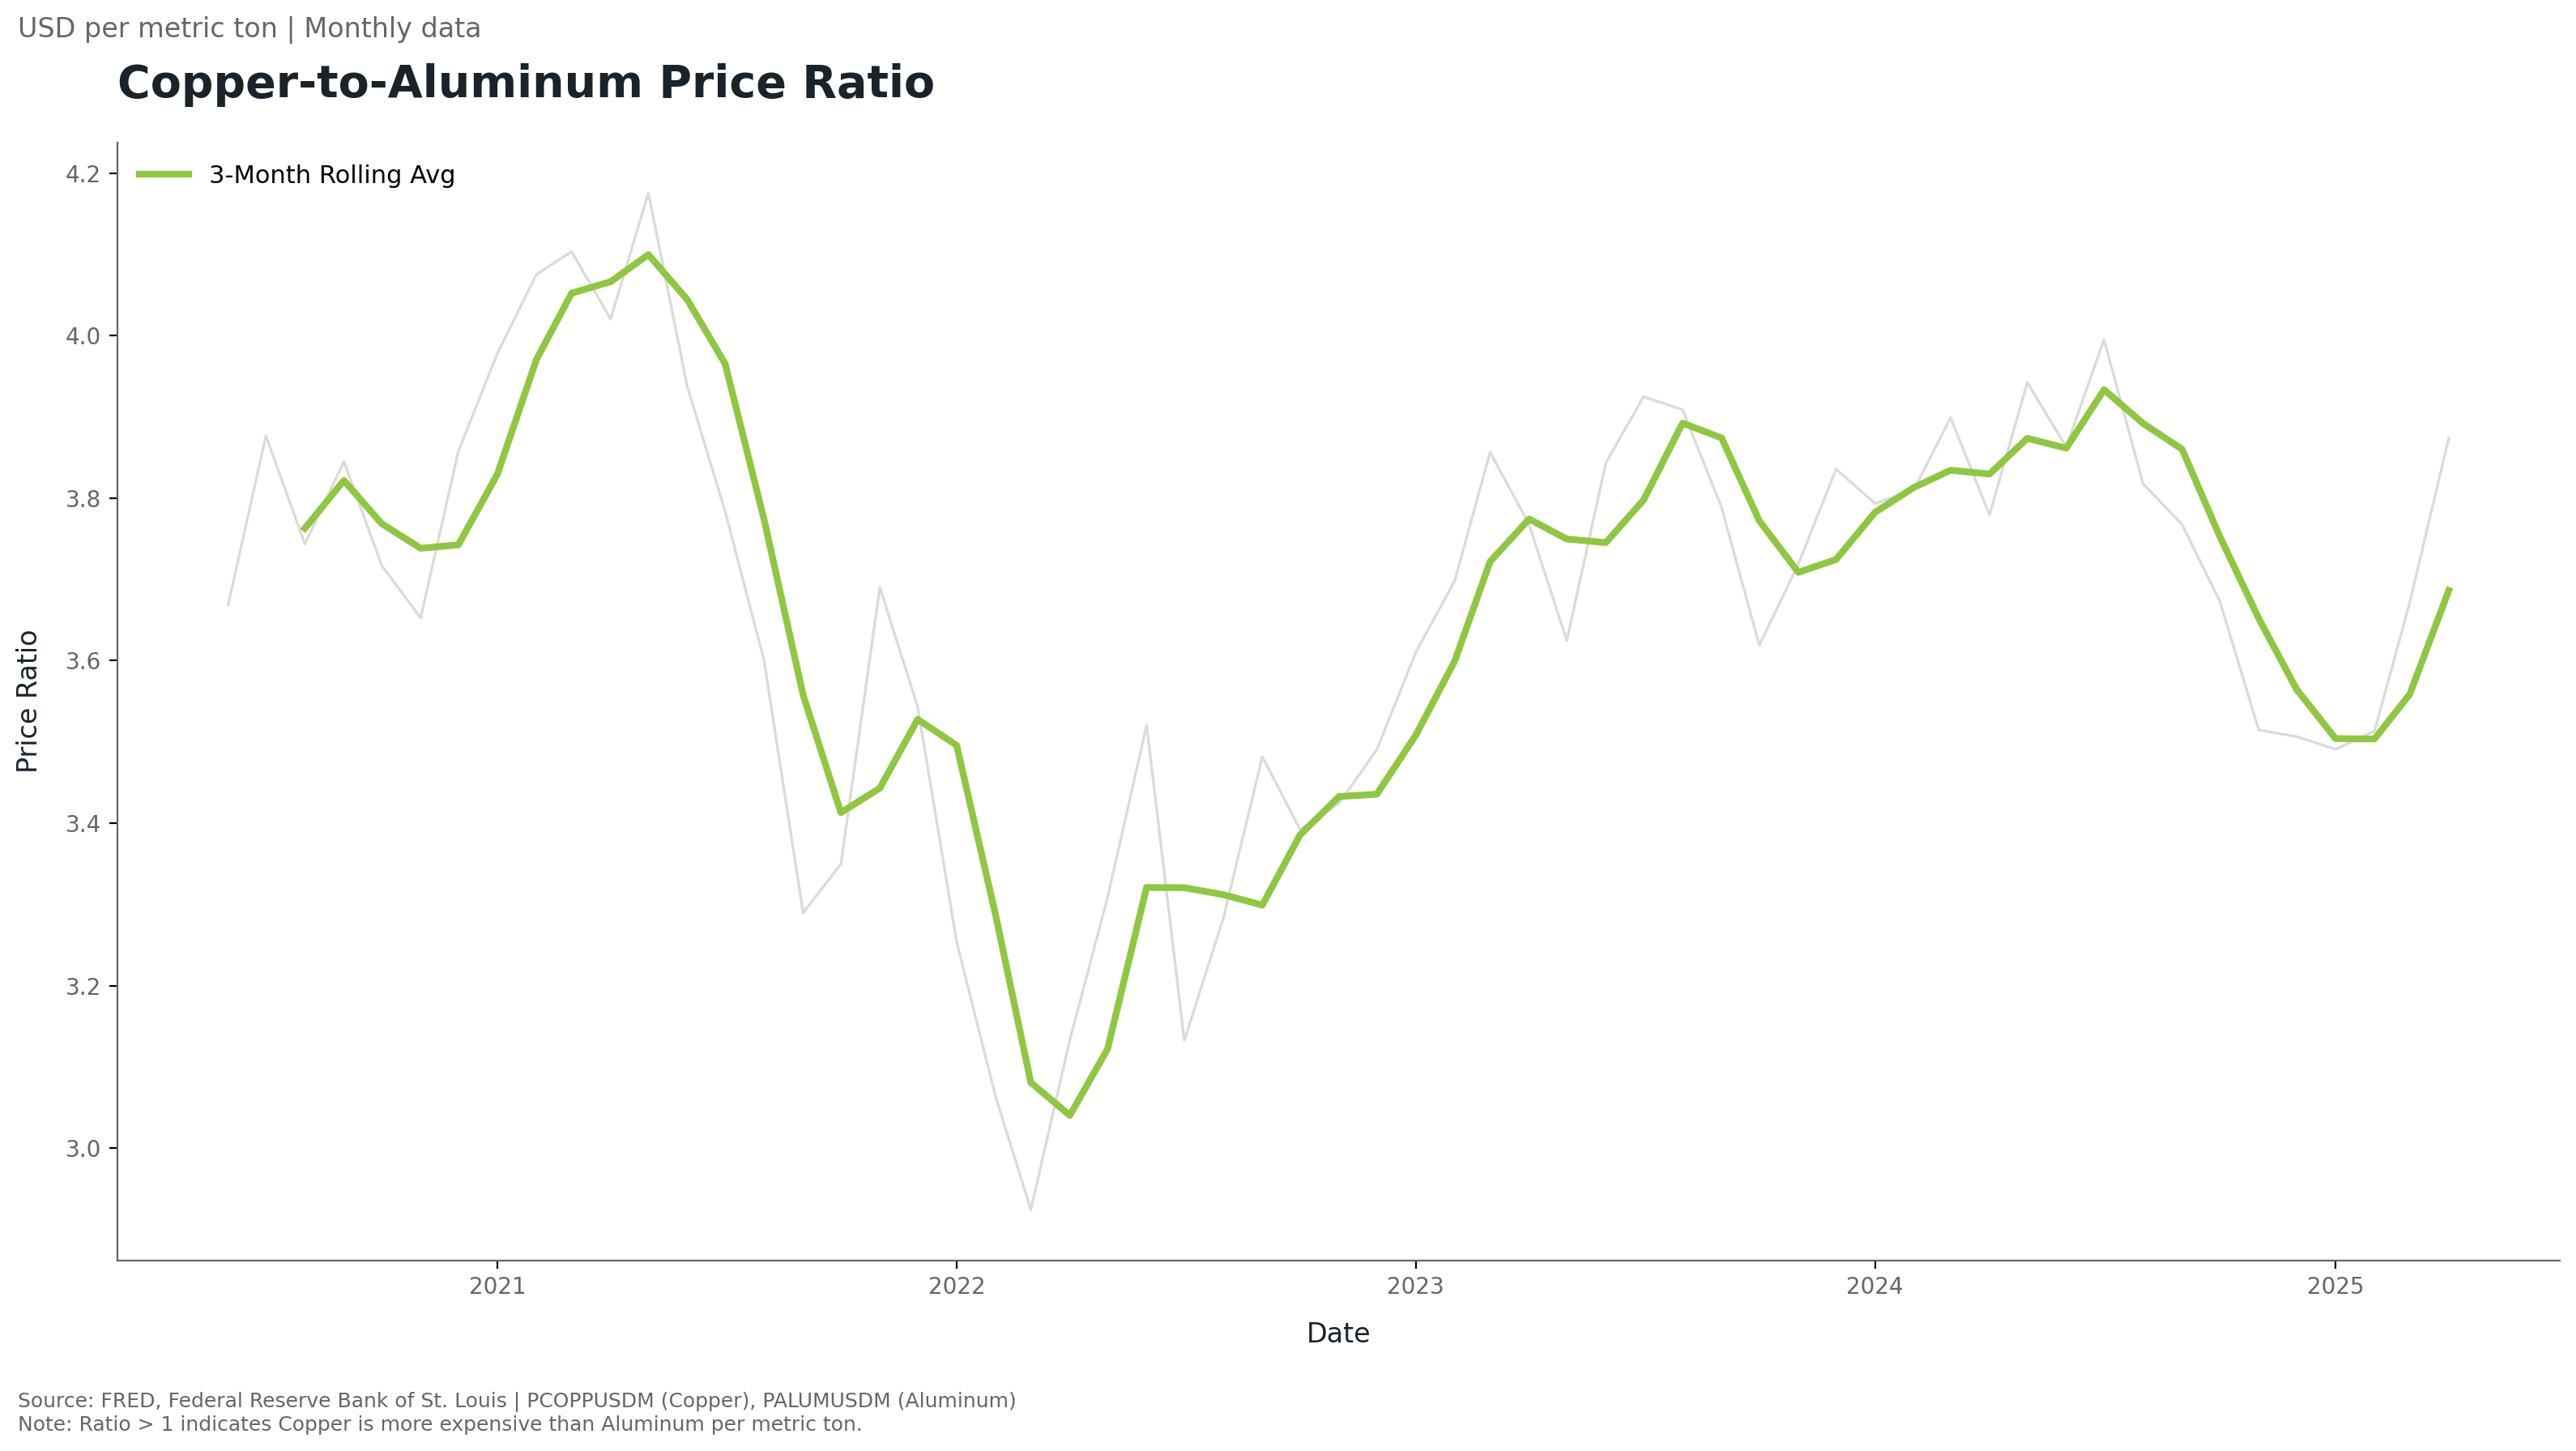

In [ ]:

green = "#8FC741"
gray = "#646762"
light_gray = "#C4C4C4"  # Lighter line for raw data
black = "#192329"
dark_blue = "#2A4F5E"



# Define series IDs
series_ids = {
    "Copper": "PCOPPUSDM",    # Copper, USD/metric ton
    "Aluminum": "PALUMUSDM"   # Aluminum, USD/metric ton
}

# Fetch time series data
start_date = "2020-06-01"
end_date = "2025-06-01"
data = {
    metal: fred.get_series(code, observation_start=start_date, observation_end=end_date)
    for metal, code in series_ids.items()
}

# Create DataFrame and calculate ratios
df = pd.DataFrame(data).dropna()
df["Ratio"] = df["Copper"] / df["Aluminum"]
df["Smoothed"] = df["Ratio"].rolling(window=3).mean()  # 3-month rolling avg

# Plotting
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(df.index, df["Ratio"], label='_nolegend_', color=light_gray, alpha=0.6, linewidth=1.2)
plt.plot(df.index, df["Smoothed"], label="3-Month Rolling Avg", color=green, linewidth=3)

# Titles and labels
plt.title("Copper-to-Aluminum Price Ratio", fontsize=20, weight='bold', color=black, loc='left', pad=20)
plt.suptitle("USD per metric ton | Monthly data", fontsize=12, color=gray, x=0.01, ha='left')
plt.xlabel("Date", fontsize=12, color=black, labelpad=10)
plt.ylabel("Price Ratio", fontsize=12, color=black, labelpad=10)

# Axis styling
plt.xticks(fontsize=10, color=gray)
plt.yticks(fontsize=10, color=gray)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color(gray)
plt.gca().spines['bottom'].set_color(gray)
plt.grid(False)  # No gridlines

# Legend
plt.legend(loc='upper left', frameon=False, fontsize=11)

# Footnote
plt.figtext(0.01, 0.01,
    "Source: FRED, Federal Reserve Bank of St. Louis | PCOPPUSDM (Copper), PALUMUSDM (Aluminum)\n"
    "Note: Ratio > 1 indicates Copper is more expensive than Aluminum per metric ton.",
    ha="left", fontsize=9, color=gray)

# Final layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [12]:
# Export to CSV
df.to_csv("copper_aluminum_ratio.csv", index=True)
